<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Implementado redes recurrentes simples<a id="top"></a>

<i>Última actualización: 2025-03-03</small></i></div>
***

## Introducción

Las redes neuronales recurrentes (RNN, del inglés _recurrent neural networks_) son un tipo de red neuronal que se utiliza para procesar datos secuenciales. A diferencia de las redes neuronales tradicionales, las RNN tienen conexiones entre los nodos que permiten que la información pase de un paso al siguiente. Esto las hace especialmente útiles para procesar datos que tienen una estructura temporal o secuencial, como las series temporales, el habla y el texto.

La idea básica de las RNN es utilizar la salida del paso anterior como entrada para el paso actual. Esto crea un bucle de retroalimentación que permite a la red mantener información sobre la secuencia que ha procesado hasta el momento. En su forma más simple, se implementan mediante unidades recurrentes simples (SRU). Las SRU son a las RNN lo que las neuronas son a las redes neuronales tradicionales. La única diferencia es que la salida de la red se concatena con la entrada, de modo que la salida anterior forma parte de la entrada actual.

## Objetivos

En este _notebook_ vamos a implementar una RNN para resolver el problema [_Fashion MNIST_](https://github.com/zalandoresearch/fashion-mnist). Aunque _Fashion MNIST_ es tradicionalmente un problema de clasificación de imágenes, lo utilizaremos como ejercicio para demostrar cómo una RNN puede procesar la imagen de una prenda leyendo sus filas de arriba a abajo, consiguiendo resultados comparables a los de las redes de convolución (CNN).

Al final habremos aprendido a:

- Crear y entrenar un modelo recurrente para resolver problemas de clasificación utilizando, para ello, una unidad recurrente simple (`RNN` en PyTorch).
- Apilar dos o más `RNN` para hacer redes recurrentes, aumentando así la potencia de estas redes.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
import torchsummary
import torchvision

import utils

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})
plt.style.use('ggplot')

Por último, establecemos las constantes de los recursos comunes.

In [3]:
DATASETS_DIR = './tmp'
BATCH_SIZE = 1024
TRAIN_EPOCHS = 25

***

## Descarga y preprocesamiento de datos

Comenzamos como en el resto de _notebooks_, descargando y preparando el conjunto `mnist` para nuestra tarea.

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_set = torchvision.datasets.FashionMNIST(
    root=DATASETS_DIR,
    train=True,
    download=True,
    transform=transform,
)
test_set = torchvision.datasets.FashionMNIST(
    root=DATASETS_DIR,
    train=False,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=BATCH_SIZE, shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False,
)

## Modelo basado en una capa de SRU

La primera capa se implementará como una RNN simple en PyTorch (usando `torch.nn.RNN`) con $10$ unidades ocultas. La entrada a esta capa serán las filas de la imagen, es decir, cada imagen se considerará como una secuencia de $28$ pasos, donde cada paso tiene $28$ características (los píxeles de cada fila).

La segunda capa será una capa lineal (implementada con `torch.nn.Linear`) que mapea los $10$ valores de salida de la `RNN` a $10$ neuronas, una para cada clase. En términos de conexiones, esto equivale a tener $10 \times 10 + 10$  conexiones ($10$ pesos por cada una de las $10$ unidades, más 10 bias).

En este caso, en lugar de encadenar las capas con `torch.nn.Sequential`, definiremos la arquitectura creando una subclase de `torch.nn.Module`. Esto nos permitirá definir un método `forward` en el que podremos: (i) procesar la entrada a través de la `RNN`, (ii) seleccionar la salida correspondiente al último step temporal, y (iii) pasar esta salida por la capa lineal para  obtener las predicciones finales.

In [5]:
class RNNModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn = torch.nn.RNN(
            input_size=28,  # Cada fila de la imagen
            hidden_size=8,  # Número de unidades (neuronas) de salida
            batch_first=True,  # Queremos formato (batch, sec_len, n_feat)
        )
        self.fc = torch.nn.Linear(in_features=8, out_features=10)
        
    def forward(self, x):
        x = x.squeeze(1)  # Nos viene con la información del canal (batch, 1, seq_len, features), pero RNN
                          #  espera (batch, seq_len, features), así que nos
                          #  información de canal
        out, _ = self.rnn(x)  # La segunda salida es la salida final.
        out = out[:, -1, :]  # (batch, sec_len, n_feat) -> La última inferencia,
                             #  es decir, sería lo mismo a la segunda salida de
                             #  rnn
        out = self.fc(out)
        return out

model = RNNModel()
torchsummary.summary(model, input_size=(28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 28, 8], [-1, 2, 8]]               0
            Linear-2                   [-1, 10]              90
Total params: 90
Trainable params: 90
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Entrenamiento del modelo

Por último, entrenaremos nuestra red. Cuidado con el tiempo de entrenamiento, ya que en el caso de las redes recurrentes es bastante lento.

In [6]:
history = utils.train(
    model=model,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=10),
)

Epoch 1/25 (7.58s), Train loss: 2.3105, Train metric: 0.1299, Val loss: 2.2416, Val. metric: 0.1382
Epoch 2/25 (7.16s), Train loss: 2.1535, Train metric: 0.2018, Val loss: 2.0713, Val. metric: 0.2575
Epoch 3/25 (7.67s), Train loss: 1.9794, Train metric: 0.2827, Val loss: 1.9073, Val. metric: 0.3062
Epoch 4/25 (7.68s), Train loss: 1.8343, Train metric: 0.3184, Val loss: 1.7690, Val. metric: 0.3272
Epoch 5/25 (8.03s), Train loss: 1.7029, Train metric: 0.3418, Val loss: 1.6416, Val. metric: 0.3538
Epoch 6/25 (7.20s), Train loss: 1.5841, Train metric: 0.3766, Val loss: 1.5365, Val. metric: 0.4149
Epoch 7/25 (7.24s), Train loss: 1.4965, Train metric: 0.4180, Val loss: 1.4666, Val. metric: 0.4209
Epoch 8/25 (8.02s), Train loss: 1.4413, Train metric: 0.4223, Val loss: 1.4253, Val. metric: 0.4373
Epoch 9/25 (6.92s), Train loss: 1.4003, Train metric: 0.4425, Val loss: 1.3827, Val. metric: 0.4534
Epoch 10/25 (7.77s), Train loss: 1.3657, Train metric: 0.4603, Val loss: 1.3510, Val. metric: 0.4592

Veamos cómo ha evolucionado la formación.

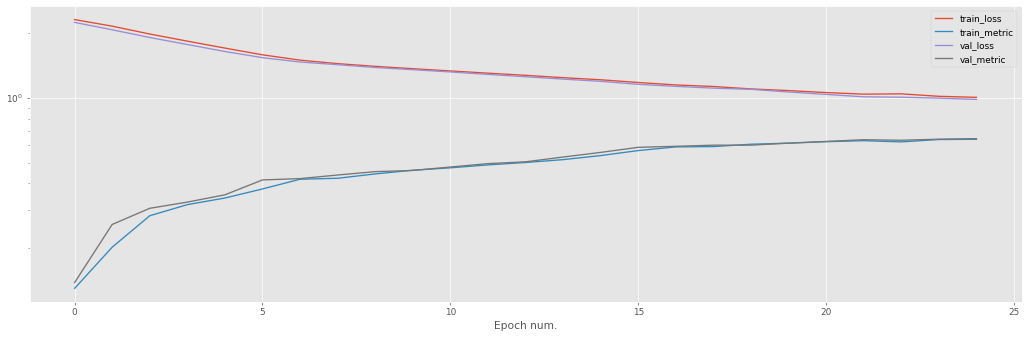

In [7]:
pd.DataFrame(history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

Podemos ver que están lejos de las precisiones conseguidas con otras técnicas de aprendizaje profundo, especialmente si las comparamos con las redes convolucionales. Pero como hemos dicho, se trata de un ejemplo de implementación, no de un caso de uso concreto.

### Clasificación de ropajes

Vamos a hacer algunas inferencias sobre el conjunto de datos de prueba. Veremos que nuestro modelo falla significativamente más que en otros casos.

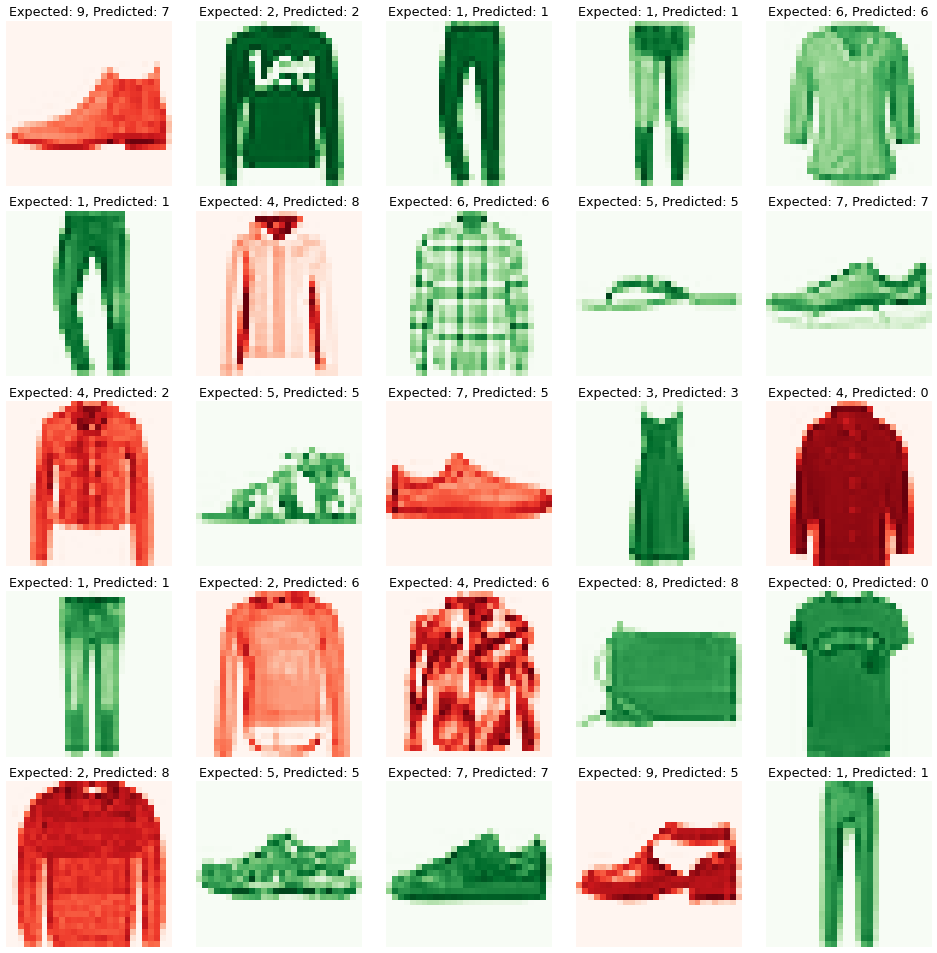

In [8]:
ROWS, COLS = 5, 5
IMAGES = ROWS * COLS

images, labels = [], []
for i in range(IMAGES):
    img, label = test_set[i]
    images.append(img)
    labels.append(label)

images_tensor = torch.stack(images)

model.eval()
with torch.no_grad():
    outputs = model(images_tensor)
    preds = torch.argmax(outputs, dim=1).numpy()

fig = plt.figure(figsize=(15, 15))
for i, (img, true_label, pred_label) in enumerate(zip(images_tensor, labels, preds), 1):
    ax = fig.add_subplot(ROWS, COLS, i)
    img_np = img.squeeze(0).numpy()
    ax.imshow(img_np, cmap='Greens' if true_label == pred_label else 'Reds')
    ax.set_title(f'Expected: {true_label}, Predicted: {pred_label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Conclusiones

Hemos aprendido a implementar una RNN simple en Keras, construyendo un modelo sencillo para clasificar las imágenes `mnist` en sus correspondientes etiquetas, demostrando cómo compilar y entrenar el modelo, y cómo evaluar su rendimiento utilizando la exactitud (_accuracy_) como métrica. En realidad, hemos hecho lo que hasta ahora, pero con redes recurrentes, y hemos visto que es prácticamente igual.

Pero al menos hemos aprendido que se puede hacer y que es fácil. Est _notebook_ nos sirve como punto de partida para implementar modelos RNN más complejos en Keras para tareas como la predicción de series temporales o el procesamiento del lenguaje natural.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>